<a href="https://colab.research.google.com/github/ASWANTH-J/av_loan_prediction_hackathon/blob/main/loan_prediction_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries,Datasets**

In [1]:
#Library for vizualizing the decision trees
!pip install dtreeviz

     |████████████████████████████████| 61 kB 548 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.1-py3-none-any.whl size=67694 sha256=af31fc76f78bd609674507ab960be9f024e89589eac63cd7c27f7848feca8cd8
  Stored in directory: /root/.cache/pip/wheels/f4/e0/4c/26144f03fd05b7c3d82e5cf2679c2d6bd9d9b730548264674d
Successfully built dtreeviz


In [2]:
#data manipulation libraries
import pandas as pd
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['image.cmap'] = 'Set1'

#classes and functions for data preprocessing
from  sklearn.preprocessing                       import  LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from  sklearn.model_selection                     import  train_test_split,StratifiedKFold

#classes for ml algorithms
from  sklearn.linear_model                        import  LinearRegression,LogisticRegression
from  sklearn.tree                                import  DecisionTreeClassifier
from  sklearn.ensemble                            import  RandomForestClassifier
#functions for model evaluation
from  sklearn.metrics                             import  accuracy_score,confusion_matrix

#functions for vizualising the model
from  dtreeviz.trees                              import dtreeviz
#for multple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#importing my own custom modules
import sys
sys.path.append('/content/drive/MyDrive/DataScience/MyLibraries/python')
from lense import classification_model_evaluation

In [3]:
#loading dataset
train = pd.read_csv('/content/drive/MyDrive/DataScience/Hackathons/av_loan_prediction/dataset/train_ctrUa4K.csv')
test = pd.read_csv('/content/drive/MyDrive/DataScience/Hackathons/av_loan_prediction/dataset/test_lAUu6dG.csv')
ss = pd.read_csv('/content/drive/MyDrive/DataScience/Hackathons/av_loan_prediction/dataset/sample_submission_49d68Cx.csv')

##**Helper Functions**

In [4]:
def plot_stacked_bar(x,cols,data,normalized=True):
  '''
  This function will plot the stacked bar chart of different categorical variables
  '''
  m=int(np.ceil(len(cols)/2))
  n= 1 if len(cols) == 1 else 2
  fig,axes = plt.subplots(m,n,figsize=(n*5,m*4))
  axes = axes.ravel() if n!=1 else axes
  plt.tight_layout()

  for i,c in enumerate(train[cols]):
    count_df = train.groupby([c,x]).size().unstack()
    if normalized:
      
      percent_df = count_df.T.div(count_df.T.sum()).T
      _=percent_df.plot(kind='bar',stacked=True,ax=axes[i] if n!=1 else axes,rot=0)
    else:
      _=count_df.plot(kind='bar',stacked=True,ax=axes[i] if n!=1 else axes,rot=0)

In [5]:
def plot_pie_chart(cols,data):

  m=int(np.ceil(len(cols)/2))
  n= 1 if len(cols) == 1 else 2
  fig,axes = plt.subplots(m,n,figsize=(n*5,m*4))
  axes = axes.ravel() if n!=1 else axes
  plt.tight_layout()

  for i,c in enumerate(train[cols]):
    _ = train[c].value_counts()[::-1].plot(kind='pie',autopct='%.0f',ax =axes[i],title=c)
    _ = axes[i].set_ylabel('')

In [6]:
def impute_missing_loan_amount(df,features):
  #A function to impute missing values present in the loan amount column
  #A simple linear regression model is used to predict the missing values
  data =df.copy()
  cat_cols = ['Gender', 'Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
  for col in list(filter(lambda i :i in features,cat_cols)) :
    le = LabelEncoder()
    data[col] = le.fit_transform(data.loc[:,col])
  m_train = data[~data.LoanAmount.isnull()]
  m_test = data[data.LoanAmount.isnull()]
  regressor = LinearRegression()
  regressor.fit(m_train[features],m_train['LoanAmount'])
  y_pred = pd.Series(data=regressor.predict(m_test[features]),index=m_test.index)
  return y_pred

In [7]:
#function for calculating emi feature
def emi_calculator(x):
  p=x[0]
  n=x[1]
  r = 0.09 / 12.0
  a=(1+r)**n
  emi = (p*r) * (a/(a-1))
  return np.round(emi*1000,2)

In [8]:
 def run_clf(clf,train,test,features,target):
  '''
  function to run a model
  it will return predicted values on train and validation set
  '''
  N_SPLITS = 5
  folds = StratifiedKFold(N_SPLITS)
  train_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])
  for trn_idx,val_idx in folds.split(train,train[target]):

    #training set
    X_train,y_train = train[features].iloc[trn_idx],train[target].iloc[trn_idx]
    #validation set
    X_val,y_val = train[features].iloc[val_idx],train[target].iloc[val_idx]
    #test set
    X_test = test[features]

    _ = clf.fit(X_train,y_train)
    pred_val=clf.predict_proba(X_val)[:,1]
    pred_test = clf.predict_proba(X_test)[:,1]

    train_preds[val_idx] = pred_val
    test_preds += pred_test.round(1) / N_SPLITS
  return train_preds,test_preds


In [9]:
def get_optimal_accuracy_thresh(target,oofs):

  '''
  A function that returns optimal threshold for a given predicted values
  '''
  thresholds = np.arange(0,100)/100
  thresh_scores=[]
  for thresh in thresholds:
    oofs_pred = (oofs > thresh)*1
    thresh_score = accuracy_score(target,oofs_pred)
    thresh_scores.append(thresh_score)

  all_thresh_scores = pd.Series(index=thresholds,data=thresh_scores)
  all_thresh_scores.plot(figsize=(10,6),fontsize=14)

  plt.xlabel('Threshold',fontsize=14)
  plt.ylabel('Accuracy Score',fontsize=14)
  
  return all_thresh_scores.sort_values(ascending = False).index.values[0]

##**Data Analysis**

In [10]:
ID,TARGET_COL = 'Loan_ID','Loan_Status'
features = [col for col in train.columns if col not in [ID,TARGET_COL]]
features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [11]:
num_cols = [
            'ApplicantIncome',
            'CoapplicantIncome',
            'LoanAmount',
            'Loan_Amount_Term'
]
cat_cols = [col for col in features if col not in num_cols]

###Brief overview of datasets

In [12]:
print(f"\nTrain set has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"\nTest set has {test.shape[0]} rows and {test.shape[1]} columns")
print(f"\nThe dataset contains initially {len(features)} features")


Train set has 614 rows and 13 columns

Test set has 367 rows and 12 columns

The dataset contains initially 11 features


In [13]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


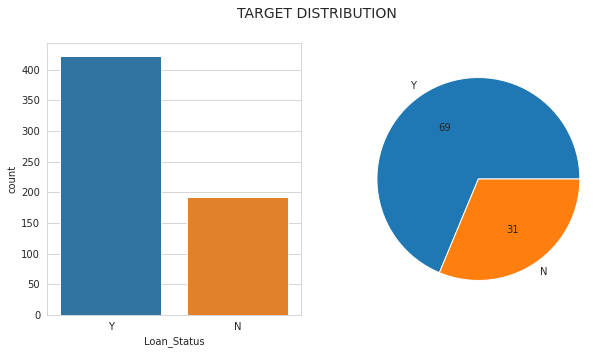

In [14]:
fig = plt.figure(figsize=(10,5))
_ =plt.suptitle('TARGET DISTRIBUTION',fontsize=14)
countplt = plt.subplot(1,2,1)
_ = sns.countplot(x=TARGET_COL,data=train)

pie=plt.subplot(1,2,2)
_ = train[TARGET_COL].value_counts().plot(kind='pie',autopct='%.0f')
_ =plt.ylabel('')



In [15]:
null_values_per_variable = ((train[features].isnull().sum()/train.shape[0]) * 100).round(3)

In [16]:
train[features].nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
dtype: int64

###Hypothesis generation

1.Does customer with loan low loan_amount_terms have higher chance to get loan?

2.Does a Customer having a property in rural areas have a lower chance to get the loan?

3.Customers supported by coapplicant who have higher income increase the chance of customer to aquiring loan

4.Do self-employed customers have less chance to get the loan?

5.Do Married People have less chance to get the loan?

###Categorical Features

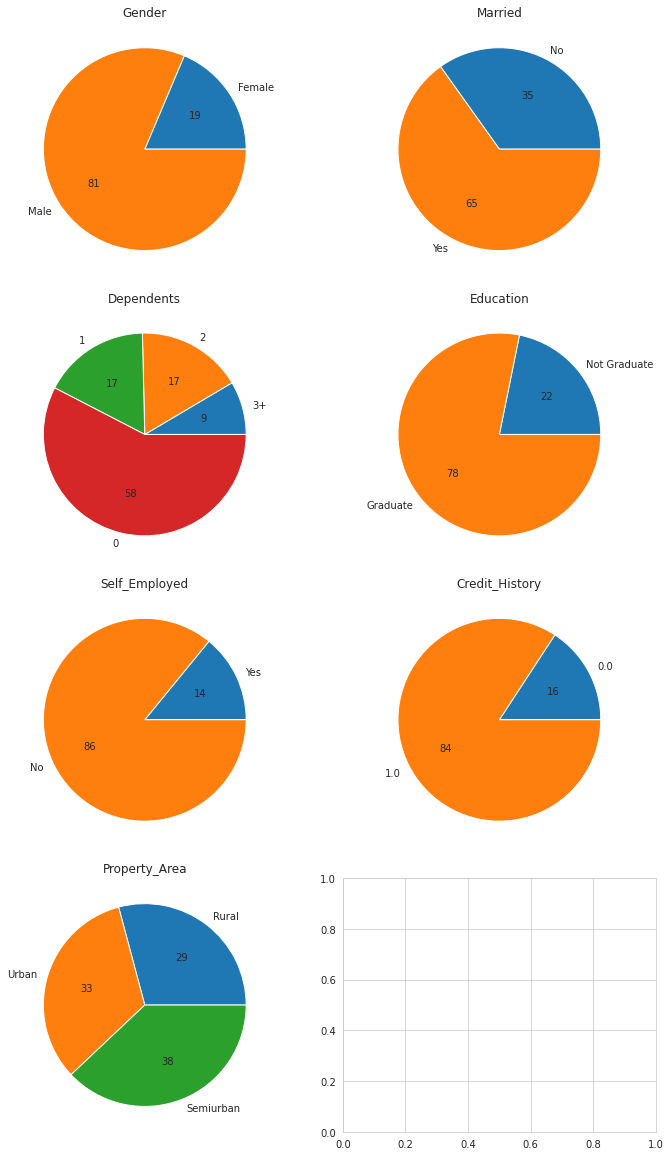

In [17]:
plot_pie_chart(cat_cols,train)

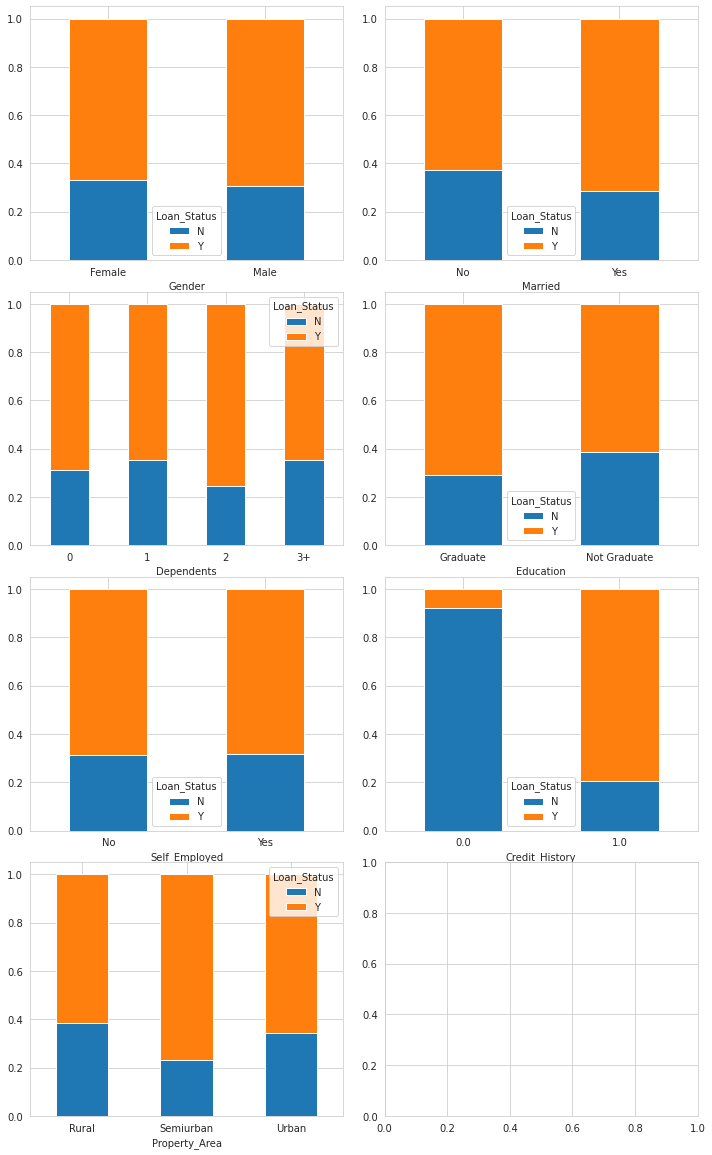

In [18]:
plot_stacked_bar(x='Loan_Status',cols=cat_cols,data=train)

Inferences:

1. Approximately 10% more of Customers who have the property in semi-urban area got the loan approved comparing other customers

2. Only few customers got the loan when they have a bad credit history

###Numerical Features

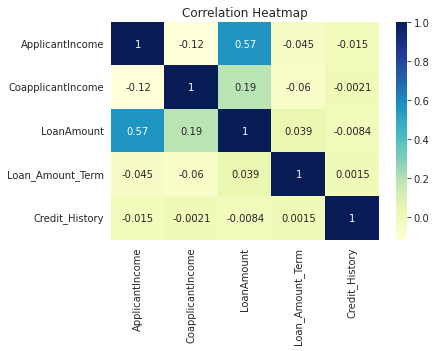

In [19]:
_=sns.heatmap(train.corr(),cmap='YlGnBu',annot=True).set_title('Correlation Heatmap')

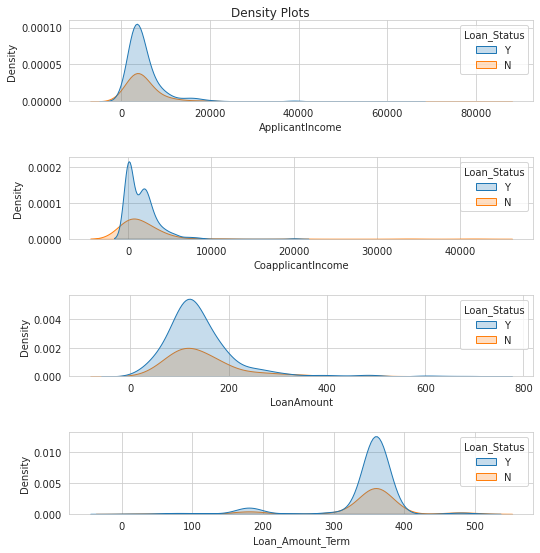

In [20]:
fig,axes= plt.subplots(4,1,figsize=(8,8))

for i,c in enumerate(num_cols):
  _ = sns.kdeplot(x=c,data=train,ax=axes[i],fill=True,hue='Loan_Status')
  _ = fig.suptitle('Density Plots')
plt.tight_layout(pad=2.5)

##Credit History

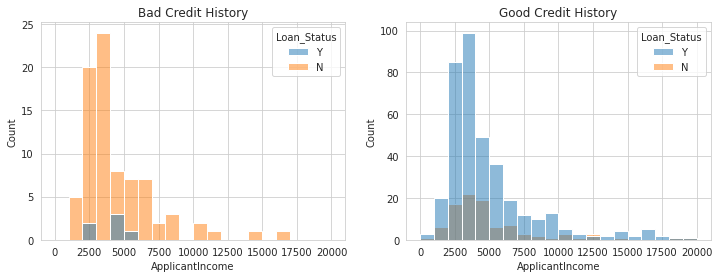

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
plt1=sns.histplot(x='ApplicantIncome',data=train[train.Credit_History==0],binrange=(0,20000),bins=20,hue=TARGET_COL,hue_order=['Y','N'],ax=ax[0])
_=plt1.set(title="Bad Credit History")

plt2=sns.histplot(x='ApplicantIncome',data=train[train.Credit_History==1],binrange=(0,20000),bins=20,hue=TARGET_COL,ax=ax[1])
plt2=plt2.set(title="Good Credit History")

In [22]:
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [23]:
train.groupby([TARGET_COL,'Credit_History']).size().unstack()

Credit_History,0.0,1.0
Loan_Status,,
N,82,97
Y,7,378


In [24]:
cols=['Gender','Married','Education','Self_Employed']

In [25]:
for col in cols:
  print(train.groupby([col,'Credit_History']).size().unstack())
  print("------------------------------------------------------\n")

Credit_History  0.0  1.0
Gender                  
Female           17   84
Male             69  382
------------------------------------------------------

Credit_History  0.0  1.0
Married                 
No               32  167
Yes              57  305
------------------------------------------------------

Credit_History  0.0  1.0
Education               
Graduate         63  380
Not Graduate     26   95
------------------------------------------------------

Credit_History  0.0  1.0
Self_Employed           
No               76  387
Yes              12   63
------------------------------------------------------



##**Data Preparation**

In [26]:
df = pd.concat([train,test],axis=0).reset_index(drop=True)
print(f"DataFrame has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

DataFrame has 981 rows and 13 columns


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


###Missing Values Imputation

In [27]:
#Adding a TotalIncome column
df['TotalIncome'] = df['ApplicantIncome']+df['CoapplicantIncome']
features.append('TotalIncome')
num_cols.append('TotalIncome')

In [28]:
#imputing missing values in categorical features
df['Gender'] = df['Gender'].fillna(df.Gender.mode()[0])
df.Married = df.Married.fillna(df.Married.mode()[0])
df.Dependents = df.Dependents.fillna(df.Dependents.mode()[0])
df.Self_Employed = df.Self_Employed.fillna(df.Self_Employed.mode()[0])
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mode()[0])

#imputing missing values in numerical features
y_pred = np.round(impute_missing_loan_amount(df,['TotalIncome','Education']),0)
df.loc[y_pred.index,'LoanAmount'] = y_pred

###Adding New Features

In [29]:
df['AmountPerIncome'] = (df['LoanAmount'] * 1000) / df['TotalIncome']
df['emi'] = df[['LoanAmount','Loan_Amount_Term']].apply(emi_calculator,axis=1)
features.extend(['AmountPerIncome','emi'])
num_cols.extend(['AmountPerIncome','emi'])

In [30]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,AmountPerIncome,emi
0,LP001002,Male,No,0,Graduate,No,5849,0.0,138.0,360.0,1.0,Urban,Y,5849.0,23.593777,1110.38
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,21.014612,1029.92
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,22.000000,531.05
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,24.286582,965.55
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,23.500000,1134.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360.0,1.0,Urban,NaN,5786.0,19.529900,909.22
977,LP002975,Male,Yes,0,Graduate,No,4158,709.0,115.0,360.0,1.0,Urban,NaN,4867.0,23.628519,925.32
978,LP002980,Male,No,0,Graduate,No,3250,1993.0,126.0,360.0,NaN,Semiurban,NaN,5243.0,24.032043,1013.82
979,LP002986,Male,Yes,0,Graduate,No,5000,2393.0,158.0,360.0,1.0,Rural,NaN,7393.0,21.371568,1271.30


In [31]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [32]:
'''col='AmountPerIncome'
train=df[:train.shape[0]]
fig,ax = plt.subplots(1,2,figsize=(12,4))
plt1=sns.histplot(x=col,data=train[train.Credit_History==0],hue=TARGET_COL,hue_order=['Y','N'],ax=ax[0],bins=20)
_=plt1.set(title="Bad Credit History")

plt2=sns.histplot(x=col,data=train[train.Credit_History==1],hue=TARGET_COL,ax=ax[1],bins=20)
plt2=plt2.set(title="Good Credit History")'''

'col=\'AmountPerIncome\'\ntrain=df[:train.shape[0]]\nfig,ax = plt.subplots(1,2,figsize=(12,4))\nplt1=sns.histplot(x=col,data=train[train.Credit_History==0],hue=TARGET_COL,hue_order=[\'Y\',\'N\'],ax=ax[0],bins=20)\n_=plt1.set(title="Bad Credit History")\n\nplt2=sns.histplot(x=col,data=train[train.Credit_History==1],hue=TARGET_COL,ax=ax[1],bins=20)\nplt2=plt2.set(title="Good Credit History")'

###Removing Outliers from training set

In [33]:
#spliting into train,test,cross validating sets
train = df.iloc[0:train.shape[0],:]
test = df.iloc[train.shape[0]:,:].reset_index(drop=True)
train,cv= train_test_split(train,test_size=0.25,random_state=42)

#removing outlier datapoints
#train=train.query('ApplicantIncome<20000 and LoanAmount<300')

train = train.reset_index(drop=True)
cv = cv.reset_index(drop=True)

train['Loan_Status'] = train['Loan_Status'].map({'Y':1,'N':0})
cv['Loan_Status'] = cv['Loan_Status'].map({'Y':1,'N':0})
data = pd.concat([train,cv,test]).reset_index(drop=True)

##**Modeling**

In [34]:
#dataframe to save best accuracy of each classification model
model_accuracy_df=pd.DataFrame(columns=['Model_Name','Training_Accuracy','Validation_Accuracy'])

In [35]:
#data preparation for logistic regression
df = data.copy()
for col in ['Gender','Dependents']:
  le = LabelEncoder()
  df.loc[:,col] = le.fit_transform(df[col])
df['Married'] = df['Married'].map({'Yes':1,'No':0})
df['Education'] = df['Education'].map({'Graduate':1,'Not Graduate':0})
df['Property_Area'] = df['Property_Area'].map({'Rural':1,'Urban':2,'Semiurban':3})
df['Self_Employed'] = df['Self_Employed'].map({'Yes':1,'No':0})
df = pd.get_dummies(df,columns=['Credit_History'])

train = df.iloc[0:train.shape[0],:]
train['Loan_Status'] = train['Loan_Status'].astype(int)
cv=df.iloc[train.shape[0]:train.shape[0]+cv.shape[0],:]
cv['Loan_Status'] = cv['Loan_Status'].astype(int)
test = df.iloc[train.shape[0]+cv.shape[0]:,:]
features = [col for col in train.columns if col not in [ID,TARGET_COL]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [36]:
df.isnull().sum()

Loan_ID                 0
Gender                  0
Married                 0
Dependents              0
Education               0
Self_Employed           0
ApplicantIncome         0
CoapplicantIncome       0
LoanAmount              0
Loan_Amount_Term        0
Property_Area           0
Loan_Status           367
TotalIncome             0
AmountPerIncome         0
emi                     0
Credit_History_0.0      0
Credit_History_1.0      0
dtype: int64

###LogisticRegression

In [37]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,Loan_Status,TotalIncome,AmountPerIncome,emi,Credit_History_0.0,Credit_History_1.0
0,LP001319,1,1,2,0,0,3273,1820.0,81.0,360.0,2,1,5093.0,15.904182,651.74,0,1
1,LP001978,1,0,0,1,0,4000,2500.0,140.0,360.0,1,1,6500.0,21.538462,1126.47,0,1
2,LP001238,1,1,3,0,1,7100,0.0,125.0,60.0,2,1,7100.0,17.605634,2594.79,0,1
3,LP001032,1,0,0,1,0,4950,0.0,125.0,360.0,2,1,4950.0,25.252525,1005.78,0,1
4,LP001711,1,1,3,1,0,3430,1250.0,128.0,360.0,3,0,4680.0,27.350427,1029.92,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,1,1,3,0,1,4009,1777.0,113.0,360.0,2,NaN,5786.0,19.529900,909.22,0,1
977,LP002975,1,1,0,1,0,4158,709.0,115.0,360.0,2,NaN,4867.0,23.628519,925.32,0,1
978,LP002980,1,0,0,1,0,3250,1993.0,126.0,360.0,3,NaN,5243.0,24.032043,1013.82,0,0
979,LP002986,1,1,0,1,0,5000,2393.0,158.0,360.0,1,NaN,7393.0,21.371568,1271.30,0,1


In [38]:
#data preparation for logistic regression
df = data.copy()
for col in ['Gender','Dependents']:
  le = LabelEncoder()
  df.loc[:,col] = le.fit_transform(df[col])
df['Married'] = df['Married'].map({'Yes':1,'No':0})
df['Education'] = df['Education'].map({'Graduate':1,'Not Graduate':0})
df['Property_Area'] = df['Property_Area'].map({'Rural':1,'Urban':2,'Semiurban':3})
df['Self_Employed'] = df['Self_Employed'].map({'Yes':1,'No':0})
df = pd.get_dummies(df,columns=['Credit_History'])

train = df.iloc[0:train.shape[0],:]
train['Loan_Status'] = train['Loan_Status'].astype(int)
cv=df.iloc[train.shape[0]:train.shape[0]+cv.shape[0],:]
cv['Loan_Status'] = cv['Loan_Status'].astype(int)
test = df.iloc[train.shape[0]+cv.shape[0]:,:]
features = [col for col in train.columns if col not in [ID,TARGET_COL]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [39]:
logit = LogisticRegression(C=1,solver='liblinear',max_iter=400)
train_preds,cv_preds = run_clf(logit,train,cv,features,TARGET_COL)
train_preds = (train_preds>0.5)*1
cv_preds = (cv_preds>0.5)*1
train_acc= accuracy_score(train[TARGET_COL],train_preds)
val_acc = accuracy_score(cv[TARGET_COL],cv_preds)
print("Training accuracy :",train_acc)
print("Validation accuracy :",val_acc)
print(confusion_matrix(cv[TARGET_COL],cv_preds))

Training accuracy : 0.7978260869565217
Validation accuracy : 0.7727272727272727
[[23 31]
 [ 4 96]]


In [40]:
model_accuracy_df.loc[len(model_accuracy_df.index)] = ['LogisticRegression', train_acc, val_acc] 

###Decision Tree

In [41]:
dtree = DecisionTreeClassifier(min_samples_split=20,max_leaf_nodes=2**3,random_state=42)
_=dtree.fit(train[features],train[TARGET_COL])
tree_train_preds = dtree.predict(train[features])
tree_val_preds = dtree.predict(cv[features])
tree_train_acc = accuracy_score(train[TARGET_COL],tree_train_preds)
tree_val_acc = accuracy_score(cv[TARGET_COL],tree_val_preds)
print("Training accuracy :",accuracy_score(train[TARGET_COL],tree_train_preds))
print("Validation accuracy :",accuracy_score(cv[TARGET_COL],tree_val_preds))
print(confusion_matrix(cv[TARGET_COL],tree_val_preds))

Training accuracy : 0.8456521739130435
Validation accuracy : 0.7987012987012987
[[27 27]
 [ 4 96]]


In [42]:
  viz = dtreeviz(dtree,train[features],train[TARGET_COL],target_name=TARGET_COL,feature_names=features,title='Loan prediction',class_names=['Yes','No'],scale=1.2)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


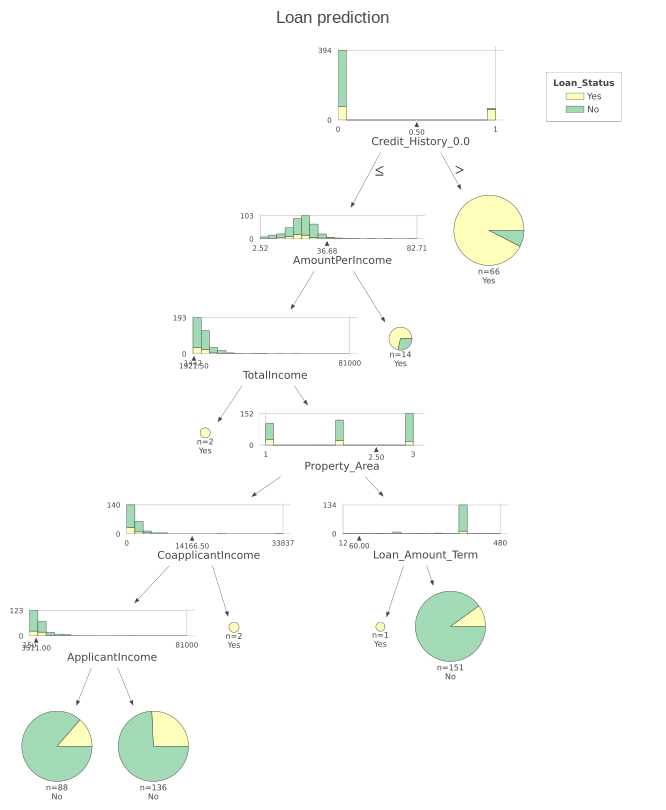

In [43]:
viz

In [44]:
feature_importances = pd.DataFrame({'feature':features,'importance':dtree.feature_importances_}).sort_values('importance',ascending=False)
feature_importances.head()

,feature,importance
13,Credit_History_0.0,0.764914
11,AmountPerIncome,0.099548
10,TotalIncome,0.034749
6,CoapplicantIncome,0.031530
9,Property_Area,0.028808


###XGBoost

In [45]:
from xgboost import XGBClassifier

In [46]:
xgb = XGBClassifier(random_state=42, n_jobs=-1,
                    n_estimators=100,colsample_bytree=0.7,min_child_weight=0.1,reg_alpha=5)
_=xgb.fit(train[features],train[TARGET_COL])
xgb_train_preds = xgb.predict(train[features])
xgb_val_preds = xgb.predict(cv[features])
print("Training Accuracy : ",accuracy_score(train[TARGET_COL],xgb_train_preds))
print("Valiidation Accuracy : ",accuracy_score(cv[TARGET_COL],xgb_val_preds))

Training Accuracy :  0.8282608695652174
Valiidation Accuracy :  0.7727272727272727
